# Import and dataset loading

In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
import copy

In [2]:
df_raw = pd.read_csv("data/spotify/genres_v2.csv")

/var/folders/63/yhtvbsns19d1qd7844r5xq880000gn/T/ipykernel_61783/758086058.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("data/spotify/genres_v2.csv")


# Proccess raw data

Remove songs with no song name and duplicates (same name and legth). Drop unneeded columns.

In [3]:
df_raw.dropna(subset='song_name', inplace=True)
df_raw.drop_duplicates(subset=["song_name", "time_signature"], keep='first', inplace=True)
df = df_raw.iloc[:, :11]
temp_columns = ["duration_ms", "time_signature", "genre","song_name"]
df[temp_columns] = df_raw[temp_columns]

Get data key info and data types.

In [4]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,15606.000000,15606.000000,15606.000000,15606.000000,15606.000000,15606.000000,15606.000000,15606.000000,15606.000000,15606.000000,15606.000000,15606.000000,15606.000000
mean,0.665807,0.657065,5.160579,-7.155312,0.577791,0.177453,0.170510,0.087753,0.195336,0.415928,152.319097,195731.998334,3.964116
std,0.161612,0.178687,3.688162,2.999485,0.493927,0.142108,0.213120,0.236953,0.152134,0.234727,28.942876,60225.622261,0.348375
min,0.065100,0.000243,0.000000,-33.357000,0.000000,0.023200,0.000001,0.000000,0.021000,0.020600,64.331000,38333.000000,1.000000
25%,0.555000,0.532000,1.000000,-8.792750,0.000000,0.054900,0.016125,0.000000,0.101000,0.219000,129.996000,152299.750000,4.000000
50%,0.686000,0.660000,5.000000,-6.789000,1.000000,0.131000,0.080850,0.000001,0.130000,0.400000,149.962000,192699.500000,4.000000
75%,0.789000,0.796000,8.000000,-5.092000,1.000000,0.277000,0.243000,0.001197,0.251000,0.593000,175.069750,231481.500000,4.000000
max,0.988000,0.999000,11.000000,2.499000,1.000000,0.944000,0.988000,0.989000,0.973000,0.980000,220.290000,728413.000000,5.000000


In [5]:
df.dtypes

danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
genre                object
song_name            object
dtype: object

### Proccesing and visualising data

Get the song counts of each genre using groupby function. Followed by apply. Apply can take a custom lambda function, or python function e.g.
* sum
* max/min
* len (count)
* avg

In [6]:
df_genre = df.groupby('genre').apply(len).reset_index(name='count')
df_genre

,genre,count
0,Dark Trap,4256
1,Emo,1327
2,Hiphop,1782
3,Pop,295
4,Rap,1039
5,RnB,1456
6,Trap Metal,1008
7,Underground Rap,4443


### Create dataframe with spcific genres
Use a mask to create dateframe with only genre=pop, and genre!=pop

In [7]:
mask = df['genre'] == 'Pop'
a, b = df[mask], df[~mask]
display(a.iloc[:3, 7:])
display(b.iloc[:3, 7:])

,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre,song_name
18038,0.0,0.1280,0.740,188.012,192191,4,Pop,My House
18039,0.0,0.0688,0.861,132.032,220227,4,Pop,Hot N Cold
18040,0.0,0.0718,0.925,117.005,188067,4,Pop,Love You Like A Love Song


,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre,song_name
0,0.013400,0.0556,0.3890,156.985,124539,4,Dark Trap,Mercury: Retrograde
1,0.000000,0.1180,0.1240,115.080,224427,4,Dark Trap,Pathology
2,0.000004,0.3720,0.0391,218.050,98821,4,Dark Trap,Symbiote


### Visualisations
Use Seaborn and plotly to visualise some data.

In [8]:
# Get a subset of our columns.
cols=df.columns[11:].values.tolist()
del cols[2]
df_viz = df.drop(columns=cols, inplace=False)

Produce a pairplot. Pair plot is used to understand the best set of features to explain a relationship between two variables. We can see below how each features varies with each other feature and how this relates to the genre of music.

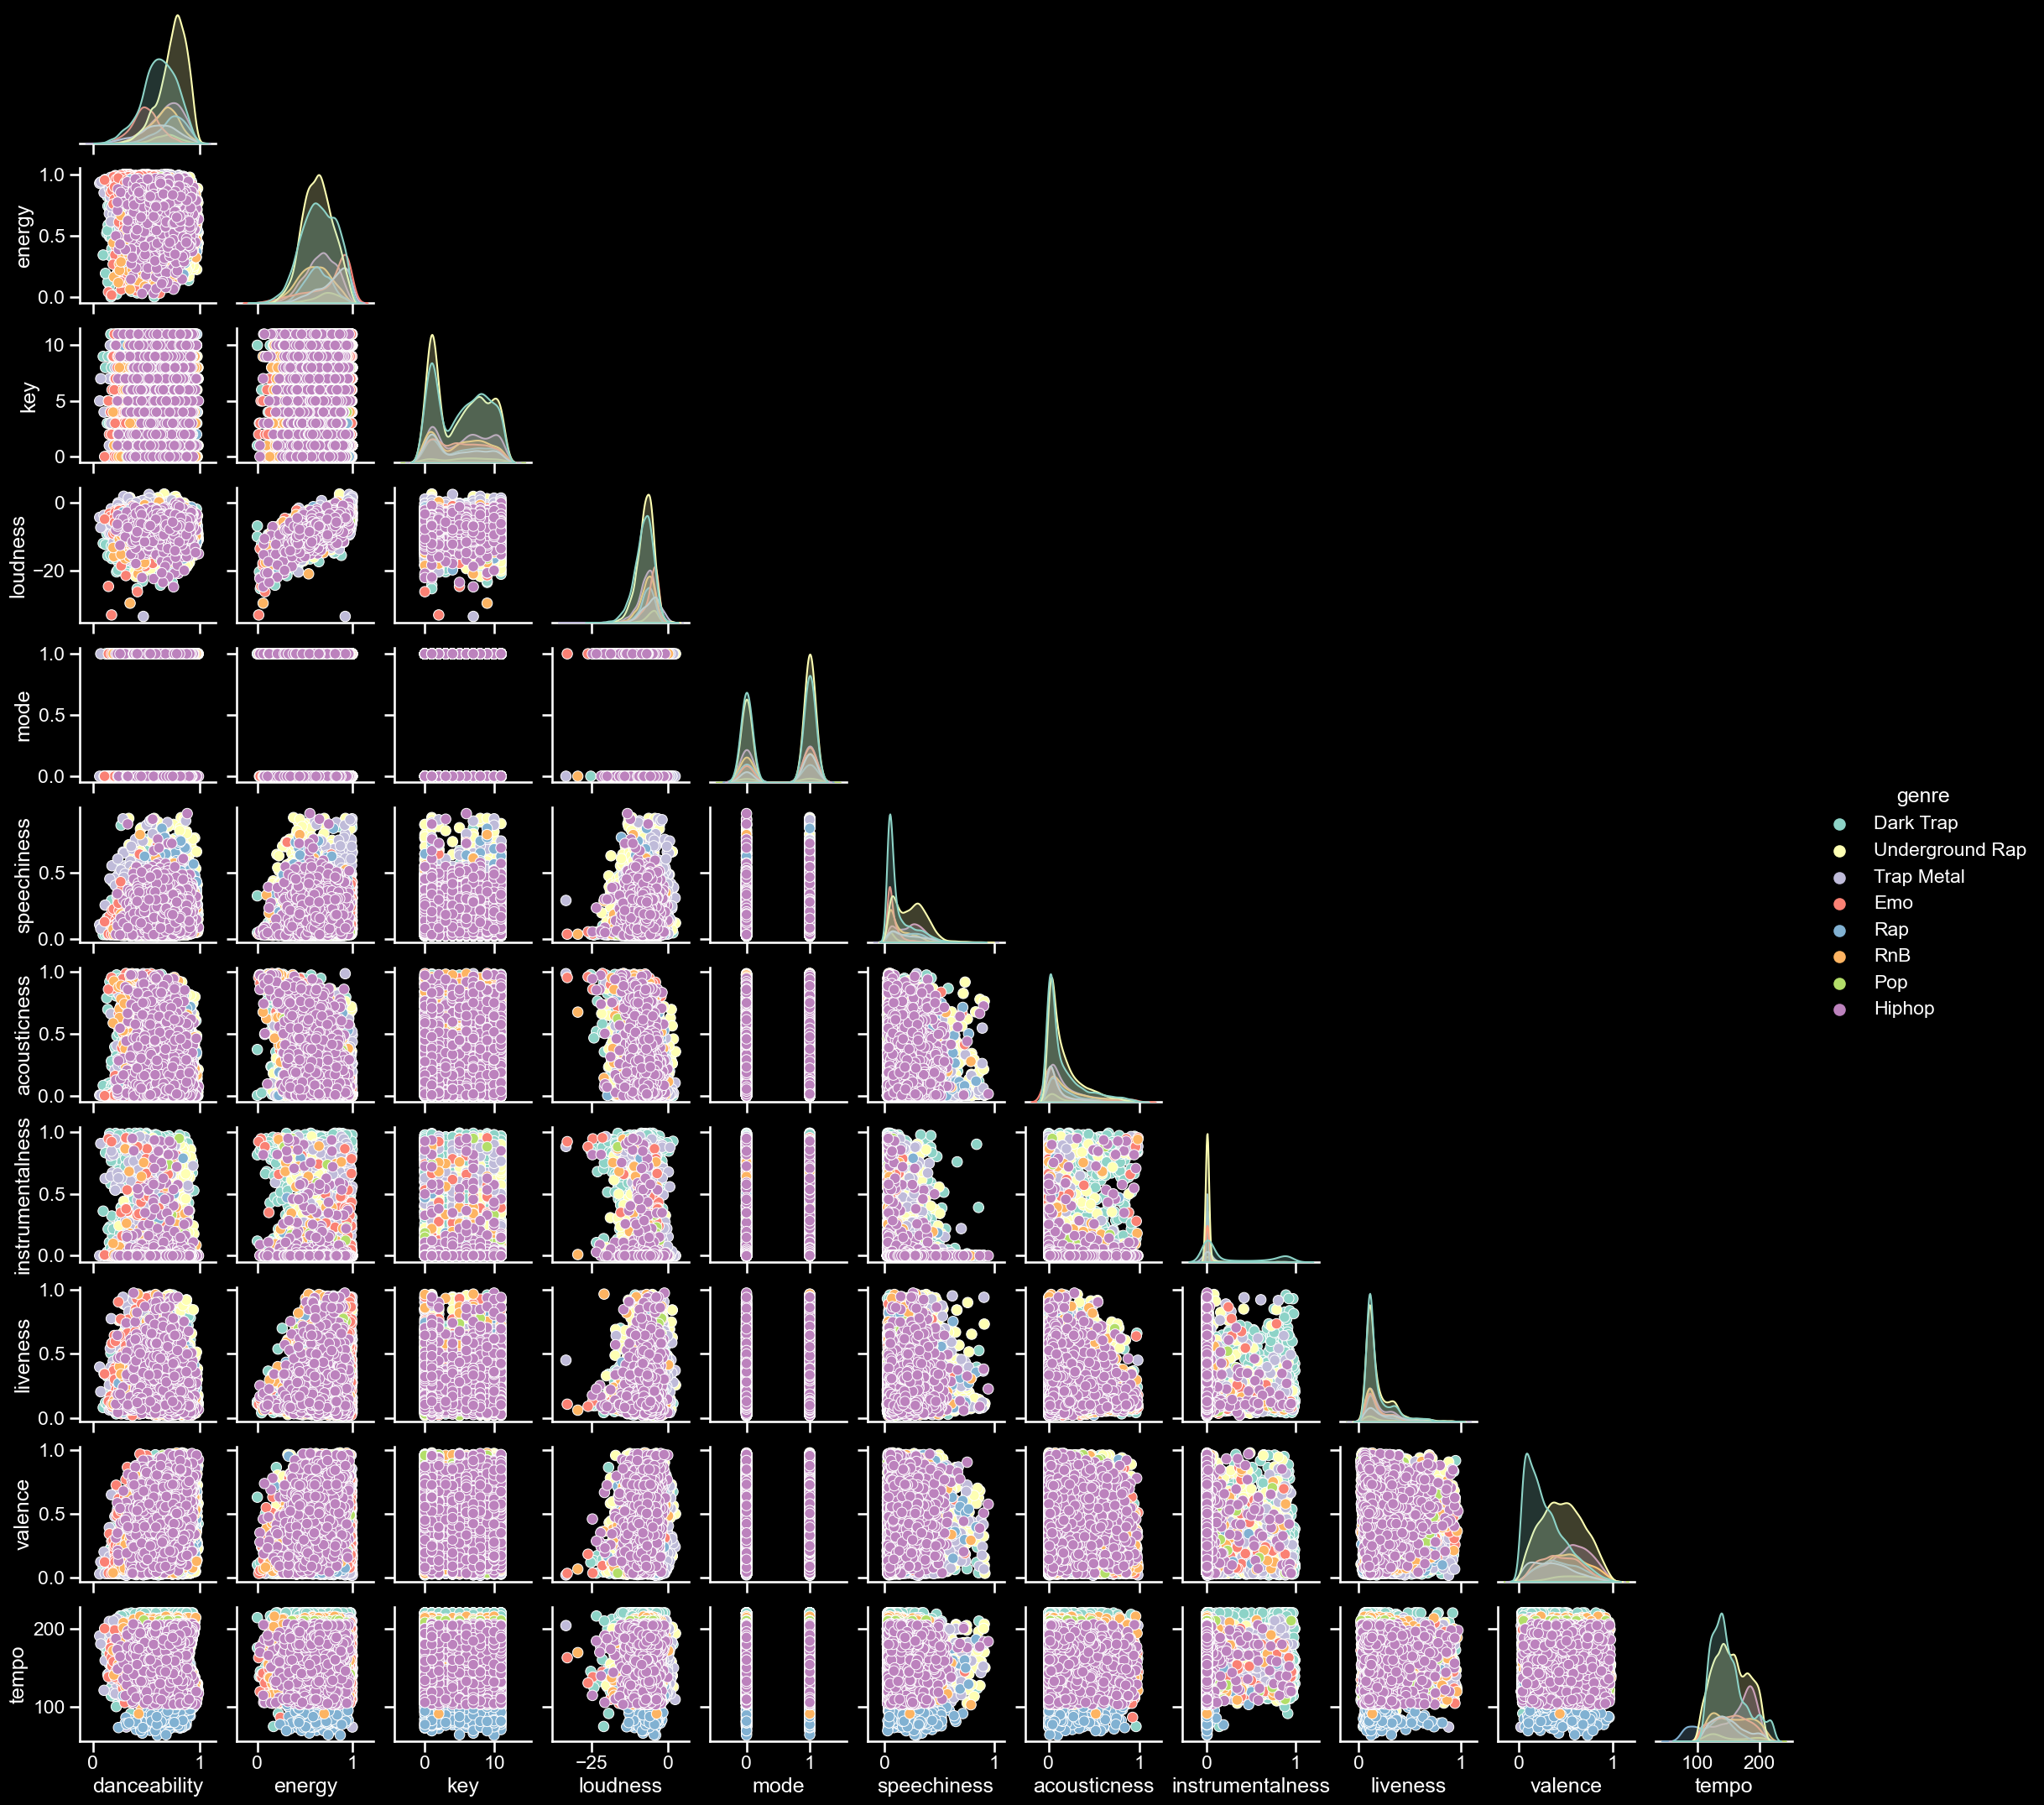

In [21]:
sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
sns.pairplot(df_viz, corner=True, hue='genre', height=2)

We can use Plotly to plot the song length for each song, split by genre.

In [19]:
px.box(df, y='duration_ms', color='genre', hover_name='song_name', width=900, height=600)

We cna also make a heatmap of the data to understand the correlation between input features

In [40]:
fig = go.Figure(
    data=go.Heatmap(
        z=np.array(df.corr().values),
        x=list(df.corr().columns),
        y=list(df.corr().index),
        hoverongaps = False
    )
)
fig.update_layout(
    autosize=False,
    width=900,
    height=600)
    
fig.show()

# Building a genre prediction classifier

First we can standarse the features using Scikit-leanrs StandardScaler. 

Standardize features by removing the mean and scaling to unit variance. The standard score of a sample x is calculated as:

$$
    z = \frac{(x - \mu)}{s}
$$

Where $\mu$ is the mean and $s$ is the standard deviation. 

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).

In [41]:
df_p = copy.copy(df)
X = df_p[df_p.drop(columns=['song_name','genre']).columns]
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)
df_p[df_p.drop(columns=['song_name','genre']).columns] = X_scaled
df_p

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre,song_name
0,1.022195,0.878296,-0.856980,-0.069577,0.854828,1.706837,-0.519487,-0.313798,-0.918535,-0.114723,0.161216,-1.182143,0.103006,Dark Trap,Mercury: Retrograde
1,0.329153,-0.918199,0.769899,-0.024901,0.854828,-0.690015,1.081540,-0.370351,-0.508357,-1.243730,-1.286682,0.476474,0.103006,Dark Trap,Pathology
2,1.139765,1.320424,-0.043541,0.790932,0.854828,-0.810350,-0.735335,-0.370334,1.161276,-1.605438,2.271129,-1.609184,0.103006,Dark Trap,Symbiote
3,-1.174500,0.693610,-1.399273,0.815270,0.854828,-0.523939,-0.688881,-0.370351,-0.534651,-1.026449,1.196495,-1.196722,-2.767554,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote)
4,0.817996,-0.185050,-0.856980,-0.170931,0.854828,0.813119,0.218149,-0.370351,-0.192836,0.745878,-0.149648,-1.202749,0.103006,Dark Trap,Venom
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21519,-0.865106,0.906279,0.498752,0.142466,0.854828,0.848305,-0.790423,-0.370337,0.924635,0.703274,0.262280,1.430567,0.103006,Hiphop,"H20 (feat. Pharoahe Monch, Rakaa Iriscience, &..."
21520,-0.790852,0.906279,-1.128126,0.125130,0.854828,2.037582,-0.760016,-0.370351,-0.422904,-0.698398,0.275721,0.229976,0.103006,Hiphop,Daddy's Girl
21521,-1.551960,-0.610388,0.498752,-0.469325,0.854828,0.756822,0.250995,-0.370351,-0.482064,0.477473,0.067477,0.301642,0.103006,Hiphop,'94
21522,0.737553,-0.050733,0.498752,0.082788,0.854828,0.714599,-0.726419,-0.361995,-0.626678,0.383744,1.100164,1.264203,0.103006,Hiphop,Born 2 Live


Split the x and Y data

In [50]:
cols=df_p.columns[:13].values.tolist()
X = df_p[cols]
y = df_p['genre']

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Models

We will train 3 different models for classification

* Logistic Regression
* K-Nearest Neighbours
* Random Forest

In [56]:
models={
       "LogReg": LogisticRegression(),
       "KNN": KNeighborsClassifier(),
       "Random Forest": RandomForestClassifier()
       }

In [60]:
def fit_models(
    models: dict, 
    X_train: pd.DataFrame, 
    X_test: pd.DataFrame, 
    y_train: pd.DataFrame, 
    y_test: pd.DataFrame
    ) -> dict:
    """
    Fits and evalues each model
    """
    model_scores = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        model_scores[name]=  model.score(X_test, y_test)
    return model_scores

In [61]:
model_scores = fit_models(models, X_train, X_test, y_train, y_test)
model_scores

{'LogReg': 0.5259449071108264,
 'KNN': 0.4676489429852659,
 'Random Forest': 0.5541319666880204}

In [71]:
fig = go.Figure(
    go.Bar(
        y=list(model_scores.keys()),
        x=list(model_scores.values()),
        orientation='h'
        )
    )
fig.show()

## Hyperparameter tuning

First we can do manual tuning of KNN by looping through a range of vales for n.

In [74]:
train_scores=[]
test_scores=[]
neighbors = range(1,15)
knn=KNeighborsClassifier()
#Loop through different neigbors
for i in neighbors:
    knn.set_params(n_neighbors=i)
    knn.fit(X_train,y_train) #Fit the model
    train_scores.append(knn.score(X_train,y_train))
    test_scores.append(knn.score(X_test,y_test))

In [78]:
df_knn = pd.DataFrame(list(zip(list(range(1,15)), train_scores, test_scores)), columns =['n', 'train_scores', 'test_scores'])
fig = px.line(df_knn, x='n', y=['train_scores', 'test_scores'])
fig.show()

It looks like the best test results are acheived on k=15, but the best training when n=1.

**Hyperparameter tuning with RandomizedSearchCV for LogReg and Random Forest models**

In [80]:
#Hyperparameter grid for Logistic Regression
log_reg_grid={
    "C": np.logspace(-4, 4, 20),    # Regularisation strength (L2) smaller -> more reg. Spread evenly on log scale. 
    "solver": ["liblinear"]         # Algorithm to use in the optimization problem. For small datasets, ‘liblinear’ is a good choice. 
    }

In [81]:
#Hyperparameter grid for Random Forest
rf_grid={
    "n_estimators": np.arange(10, 1000, 50),    # The number of trees in the forest.
    "max_depth": [None, 3, 5, 10],              # The maximum depth of the tree.
    "min_samples_split": np.arange(2, 20, 2),   # The minimum number of samples required to split an internal node.
    "min_samples_leaf": np.arange(1, 20, 2)     # The minimum number of samples required to be at a leaf node.
    }

Perform Random search 

In [82]:
rs_log_reg=RandomizedSearchCV(LogisticRegression(),
                             param_distributions = log_reg_grid,
                             cv = 5,        # 5-fold cross-validation splitting strategy. 
                             n_iter = 20,   # Number of parameter settings that are sampled
                             verbose = True) 

rs_log_reg.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

Get the best parameters and test score with best parameters. 

In [83]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 0.615848211066026}

In [84]:
rs_log_reg.score(X_test,y_test)

0.5185778347213325

In [85]:
rs_rf=RandomizedSearchCV(RandomForestClassifier(),
                        param_distributions=rf_grid,
                        n_iter=20,
                        verbose=True)
rs_rf.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(estimator=RandomForestClassifier(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

In [86]:
rs_rf.best_params_

{'n_estimators': 910,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_depth': None}

In [87]:
rs_rf.score(X_test, y_test)

0.5640614990390775

## Evaluate the tuned model with other metrics

* Classification Report
* Precision
* Recall
* F1 Score

First lets check the test predictions vs true values

In [90]:
y_preds = rs_rf.predict(X_test)
comparison = pd.DataFrame({"actual": y_preds, "prediction": y_test})
comparison.head()

,actual,prediction
19570,Hiphop,Hiphop
7181,Underground Rap,Underground Rap
10881,Emo,Trap Metal
16159,RnB,RnB
20355,Underground Rap,Hiphop


In [92]:
print(classification_report(y_test, y_preds))

                 precision    recall  f1-score   support

      Dark Trap       0.64      0.68      0.66       855
            Emo       0.77      0.74      0.75       268
         Hiphop       0.50      0.34      0.40       334
            Pop       0.40      0.04      0.07        53
            Rap       0.98      0.24      0.39       213
            RnB       0.44      0.43      0.44       293
     Trap Metal       0.66      0.31      0.43       226
Underground Rap       0.48      0.70      0.57       880

       accuracy                           0.56      3122
      macro avg       0.61      0.44      0.46      3122
   weighted avg       0.59      0.56      0.55      3122

